# L0,L1 smoothness and Frank-Wolfe on log regression

### Целевая функция

Будем оптимизировать задачу бинарной классификации
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \text{log}(1 + \text{exp}(-y_i (Ax)_i))
$$
, где $x \in \mathbb{R}^d$, $L= \text{max}_i \| A_i \|^2$, $L_0 = 0$, $L_1 = \text{max}_i \| A_i \|$ $(\| A_i \| >> 1)$

### Данные 
Эксперименты проводились на следующих данных:
- $a_i$ – случайный вектор из $\mathbb{R}^d$, взятый из нормального распределения
- Датасет a9a Platt (1998), доступный из библиотеки LIBSVM

Начальная точка x0 = [0, 0, 0, ...] + \epsilon

### Алгоритмы
В экспериментах сравниваются следующие методы:
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости (FW-L0_L1)
- Алгоритм Франк-Вульфа классический (FW-stand) с shortest step
- (Пока убрал, т.к. пока смысла не увидел в нем тут) Алгоритм Франк-Вульфа c убывающим шагом  (FW-desc)

### Цель эксперимента

Ответим на вопросы
1) Будет ли FW-L0_L1 быстрее, чем FW-stand? 
2) Посмотреть на разных диаметрах множества, т.к. ожидаю, что алгоритм $L_0,L_1$ будет быстрее на мелких диаметрах
3) Опционально. Было бы интересно посмотреть сколько раз выполняется каждый из видов шага, часто ли будет переключаться на логарифмический шаг?

In [12]:
import sys
import os

# Get the parent directory of the notebook (2 levels up)
notebook_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)

In [13]:
from matplotlib.ticker import ScalarFormatter
import numpy as np
import matplotlib.pyplot as plt

import accbpg
from accbpg.utils import random_point_on_simplex

## Лог функция, адаптивные параметры

### Меняем размерность и число векторов

radius is  250
true omega radius is  237.66645772751588
ratio positive labels: 0.505

FW L0,L1 smooth algorithm
     k      F(x)         L        log step count       time
     0    6.931e-01    4.244e+00        1         0.1
    60    6.371e-03    2.992e-02       61         0.2
   120    9.462e-04    8.832e-04      121         0.2
   180    1.649e-04    3.359e-04      181         0.2
   240    4.787e-05    9.720e-05      241         0.3
   300    8.487e-06    3.777e-05      301         0.3
   360    1.054e-06    4.690e-06      361         0.3
   420    1.677e-07    7.462e-07      421         0.3
   480    4.889e-08    9.966e-08      481         0.4
   540    1.632e-08    7.455e-08      541         0.4

FW adaptive algorithm
     k      F(x)         Lk       time
     0   6.931e-01   4.428e+01     0.0
    60   1.024e-02   2.162e-02     0.0
   120   2.012e-03   5.405e-03     0.0
   180   4.605e-04   1.351e-03     0.1
   240   1.315e-04   3.378e-04     0.1
   300   3.595e-05   3.378e-04 

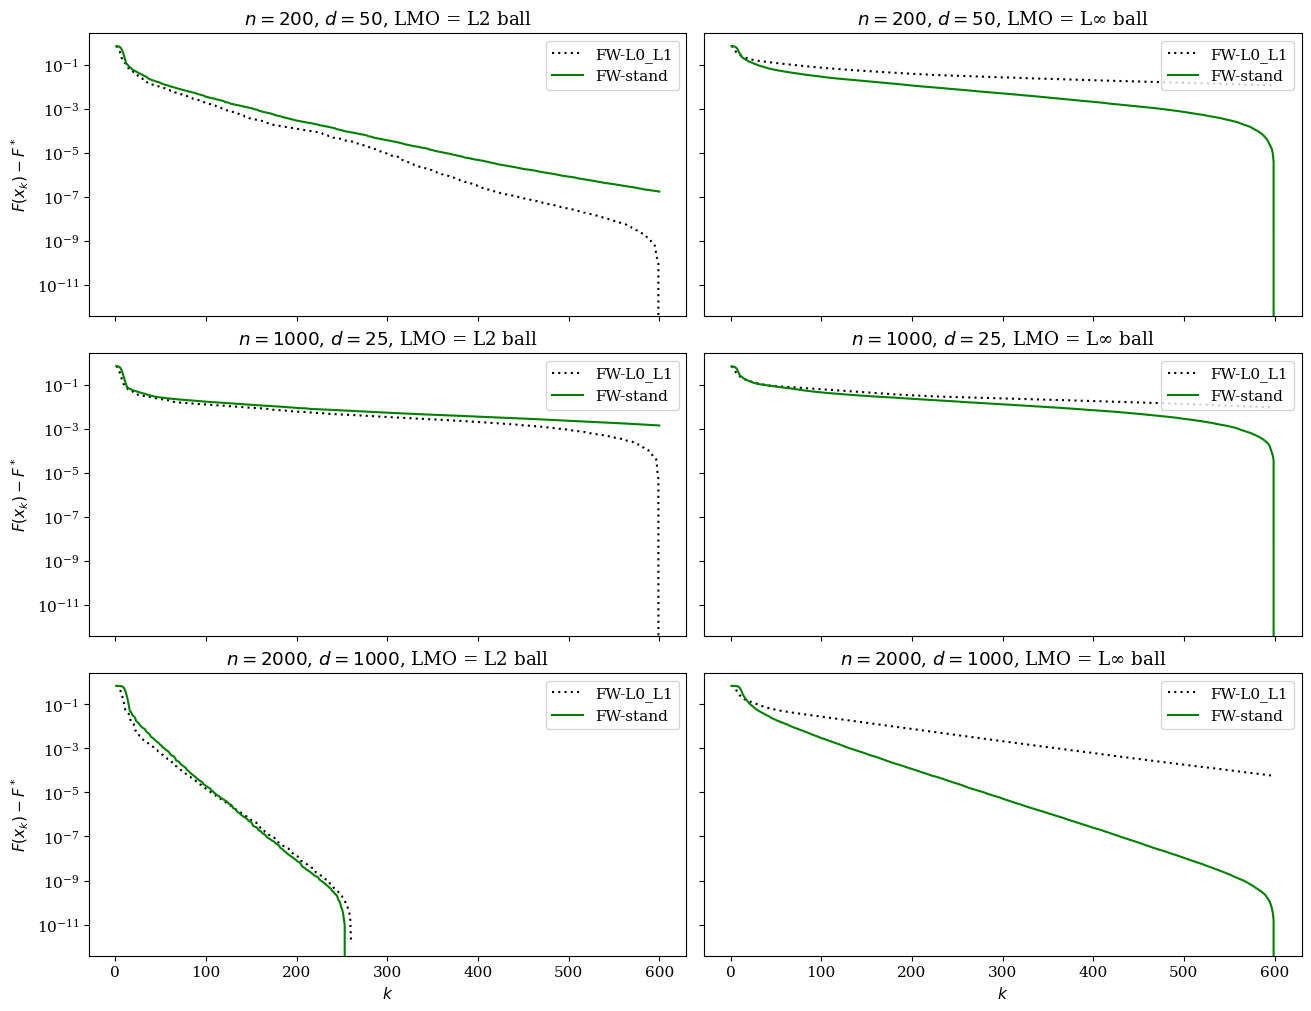

In [18]:
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

fig, axes = plt.subplots(3, 2, figsize=(13, 10), sharex=True, sharey=True, constrained_layout=True)

eps = 1e-14
max_iters = 600
verbskip = max_iters / 10
ls_ratio = 2.2

ball_constrnt_radius = 250
# n_samples, n_features = 1000, 25

solution_spread_radius_btm = 0.95
solution_spread_radius_up = 0.99

labels = [r"FW-L0_L1", r"FW-stand"]

configs = [
    (200, 50),
    (1000, 25),
    (2000, 1000),
]

lmo_names = ["L2 ball", "L∞ ball"]

for i, (n_samples, n_features) in enumerate(configs):
    f, h, L, L0, L1, x0 = accbpg.L0L1_FW_log_reg(n_samples, n_features, ball_constrnt_radius, 
                                                 solution_spread_radius_btm=solution_spread_radius_btm, 
                                                 solution_spread_radius_up=solution_spread_radius_up)

    for j, (lmo, lmo_name) in enumerate(zip(
        [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)], lmo_names
    )):
        _, F_l0l1, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        _, F_standard, _, _ = accbpg.FW_alg_div_step(
            f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        ax = axes[i, j]
        accbpg.plot_comparisons(
            ax,
            [F_l0l1, F_standard],
            labels,
            x_vals=[], plotdiff=True, yscale="log",
            xlabel=r"$k$" if i == 2 else "",
            ylabel=r"$F(x_k) - F^*$" if j == 0 else "",
            legendloc="upper right"
        )

        ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, LMO = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()


### Меняем радиус допустимого множества

radius is  1.0
true omega radius is  0.9660436950793231
ratio positive labels: 0.525

FW L0,L1 smooth algorithm
     k      F(x)         L        log step count       time
     0    6.931e-01    2.750e+00        1         0.1

FW adaptive algorithm
     k      F(x)         Lk       time
     0   6.931e-01   2.391e+01     0.0

FW L0,L1 smooth algorithm
     k      F(x)         L        log step count       time
     0    6.931e-01    2.750e+00        1         0.0
    60    2.455e-01    1.501e-01       61         0.0
   120    2.350e-01    1.431e-01      121         0.1
   180    2.315e-01    1.403e-01      181         0.1
   240    2.297e-01    1.395e-01      241         0.1
   300    2.287e-01    1.385e-01      301         0.2
   360    2.280e-01    1.379e-01      361         0.2
   420    2.275e-01    1.376e-01      421         0.2
   480    2.272e-01    1.375e-01      481         0.3
   540    2.268e-01    1.372e-01      541         0.3

FW adaptive algorithm
     k      F(x)       

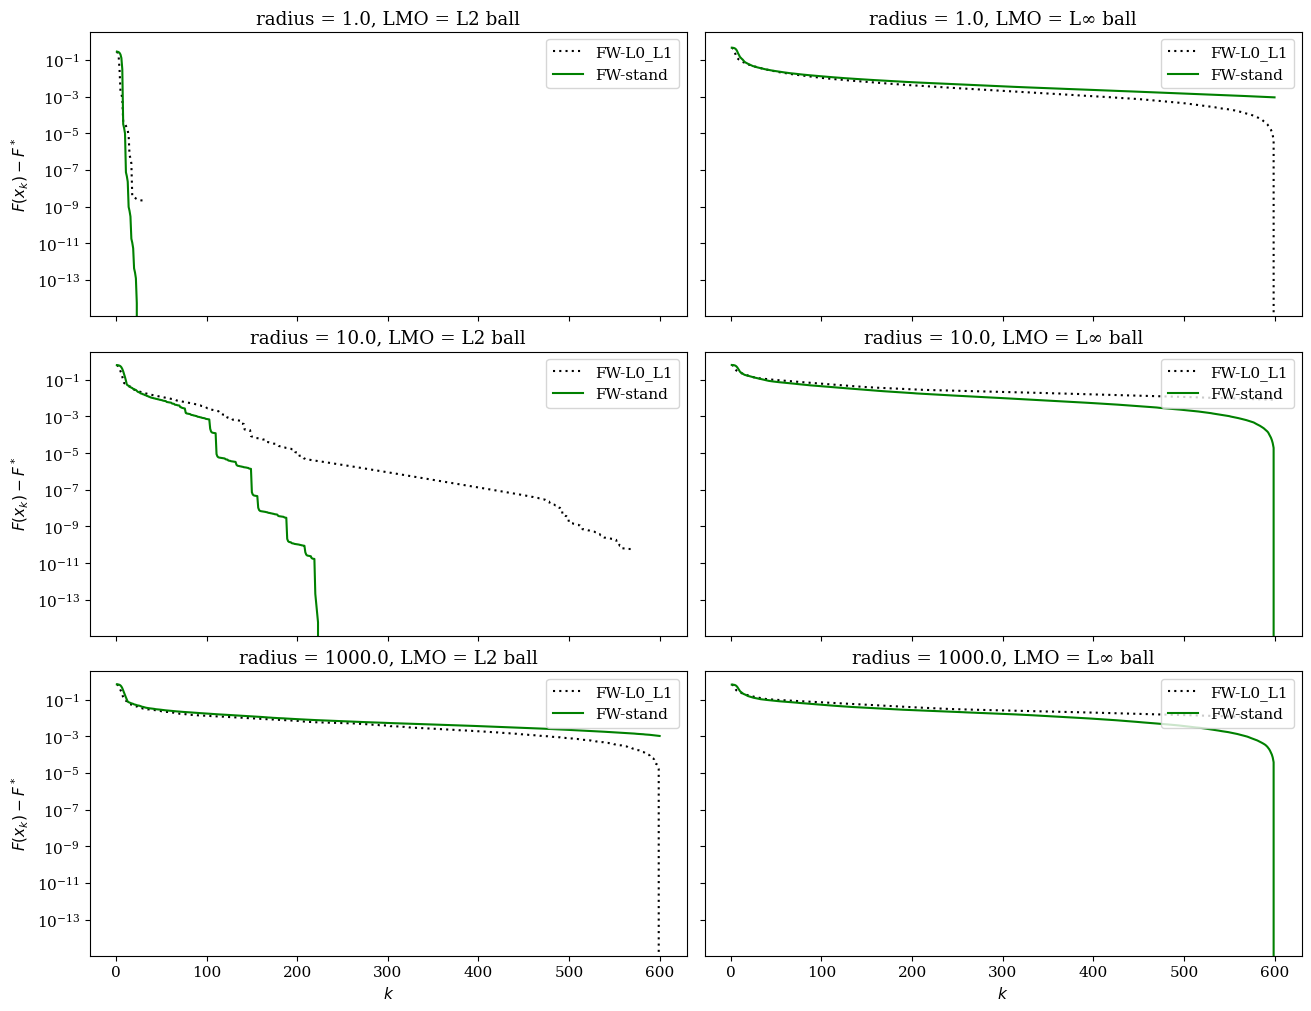

In [23]:
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

fig, axes = plt.subplots(3, 2, figsize=(13, 10), sharex=True, sharey=True, constrained_layout=True)

eps = 1e-14
max_iters = 600
verbskip = max_iters / 10
ls_ratio = 2.2

# parameters which ill be variated
# ball_constrnt_radius = 250
n_samples, n_features = 1000, 25

solution_spread_radius_btm = 0.95
solution_spread_radius_up = 0.99

radii = [1.0, 10.0, 1000.0]  # log-scale variation of radius
labels = [r"FW-L0_L1", r"FW-stand"]
lmo_names = ["L2 ball", "L∞ ball"]

for i, ball_constrnt_radius in enumerate(radii):
    f, h, L, L0, L1, x0 = accbpg.L0L1_FW_log_reg(
        n_samples, n_features, ball_constrnt_radius,
        solution_spread_radius_btm=solution_spread_radius_btm,
        solution_spread_radius_up=solution_spread_radius_up
    )

    for j, (lmo, lmo_name) in enumerate(zip(
        [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)], lmo_names
    )):
        _, F_l0l1, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        _, F_standard, _, _ = accbpg.FW_alg_div_step(
            f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        ax = axes[i, j]
        accbpg.plot_comparisons(
            ax,
            [F_l0l1, F_standard],
            labels,
            x_vals=[], plotdiff=True, yscale="log",
            xlabel=r"$k$" if i == 2 else "",
            ylabel=r"$F(x_k) - F^*$" if j == 0 else "",
            legendloc="upper right"
        )

        ax.set_title(f"radius = {ball_constrnt_radius}, LMO = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_vs_radius_grid.pdf", bbox_inches='tight')
plt.show()


### Меняем удаленность решения от центра шара. От ближайшего к более дальнему.

radius is  250
true omega radius is  20.051242257540313
ratio positive labels: 0.487

FW L0,L1 smooth algorithm
     k      F(x)         L        log step count       time
     0    6.931e-01    2.999e+00        1         0.1
    60    2.899e-02    1.371e-02       61         0.1
   120    2.050e-02    3.619e-03      121         0.2
   180    1.608e-02    2.567e-03      181         0.2
   240    1.298e-02    9.381e-03      241         0.3
   300    1.060e-02    1.603e-02      301         0.3
   360    8.977e-03    1.231e-03      361         0.4
   420    7.512e-03    4.828e-03      421         0.4
   480    6.688e-03    4.216e-03      481         0.5
   540    6.026e-03    1.699e-03      541         0.5

FW adaptive algorithm
     k      F(x)         Lk       time
     0   6.931e-01   2.872e+01     0.0
    60   3.368e-02   7.013e-03     0.0
   120   2.358e-02   2.805e-02     0.1
   180   1.768e-02   7.013e-03     0.1
   240   1.433e-02   7.013e-03     0.1
   300   1.237e-02   7.013e-03 

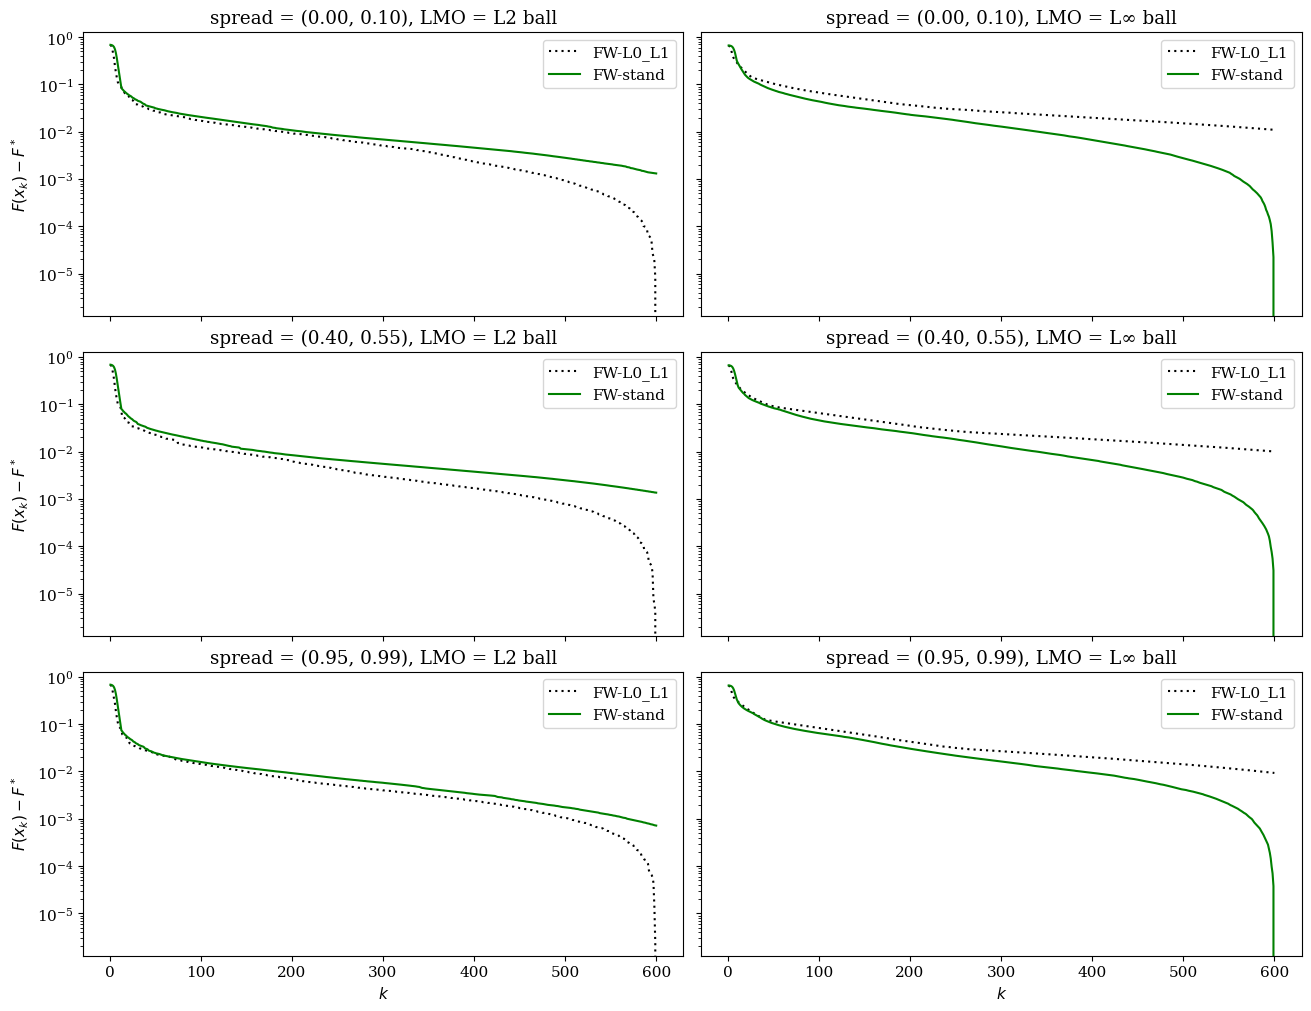

In [28]:
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

fig, axes = plt.subplots(3, 2, figsize=(13, 10), sharex=True, sharey=True, constrained_layout=True)

eps = 1e-14
max_iters = 600
verbskip = max_iters / 10
ls_ratio = 2.2

# parameters which ill be variated
ball_constrnt_radius = 250
n_samples, n_features = 1000, 25

# solution_spread_radius_btm = 0.95
# solution_spread_radius_up = 0.99

# Fixed parameters
labels = [r"FW-L0_L1", r"FW-stand"]
lmo_names = ["L2 ball", "L∞ ball"]

# The spread configurations (three rows)
spread_configs = [(0.0, 0.1), (0.4, 0.55), (0.95, 0.99)]

for i, (spread_btm, spread_up) in enumerate(spread_configs):
    np.random.seed(2025 + i)  # for reproducibility

    f, h, L, L0, L1, x0 = accbpg.L0L1_FW_log_reg(
        n_samples, n_features, ball_constrnt_radius,
        solution_spread_radius_btm=spread_btm,
        solution_spread_radius_up=spread_up
    )

    for j, (lmo, lmo_name) in enumerate(zip(
        [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)],
        lmo_names
    )):
        # FW-L0_L1
        _, F_l0l1, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        # FW-stand
        _, F_standard, _, _ = accbpg.FW_alg_div_step(
            f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        ax = axes[i, j]
        accbpg.plot_comparisons(
            ax,
            [F_l0l1, F_standard],
            labels,
            x_vals=[], plotdiff=True, yscale="log",
            xlabel=r"$k$" if i == 2 else "",
            ylabel=r"$F(x_k) - F^*$" if j == 0 else "",
            legendloc="upper right"
        )

        ax.set_title(
            fr"spread = ({spread_btm:.2f}, {spread_up:.2f}), LMO = {lmo_name}"
        )

# Optional: save the figure
# plt.savefig("FW_spread_variation_grid.pdf", bbox_inches='tight')
plt.show()


## Лог функция, фиксированные параметры

radius is  250
true omega radius is  228.71325835622196
ratio positive labels: 0.505

FW L0,L1 smooth algorithm
     k      F(x)         L        log step count       time
     0    6.931e-01    4.422e+00        1         0.1
    60    7.029e-02    2.081e-01       61         0.1
   120    1.760e-02    4.246e-02      121         0.1
   180    5.010e-03    1.168e-02      181         0.2
   240    1.457e-03    3.366e-03      241         0.2
   300    4.275e-04    9.823e-04      301         0.2
   360    1.261e-04    2.887e-04      361         0.2
   420    3.732e-05    8.526e-05      421         0.2
   480    1.107e-05    2.526e-05      481         0.2
   540    3.290e-06    7.498e-06      541         0.2

FW adaptive algorithm
     k      F(x)         Lk       time
     0   6.931e-01   7.811e+01     0.0
    60   5.461e-01   7.811e+01     0.0
   120   4.578e-01   7.811e+01     0.0
   180   3.994e-01   7.811e+01     0.0
   240   3.577e-01   7.811e+01     0.1
   300   3.261e-01   7.811e+01 

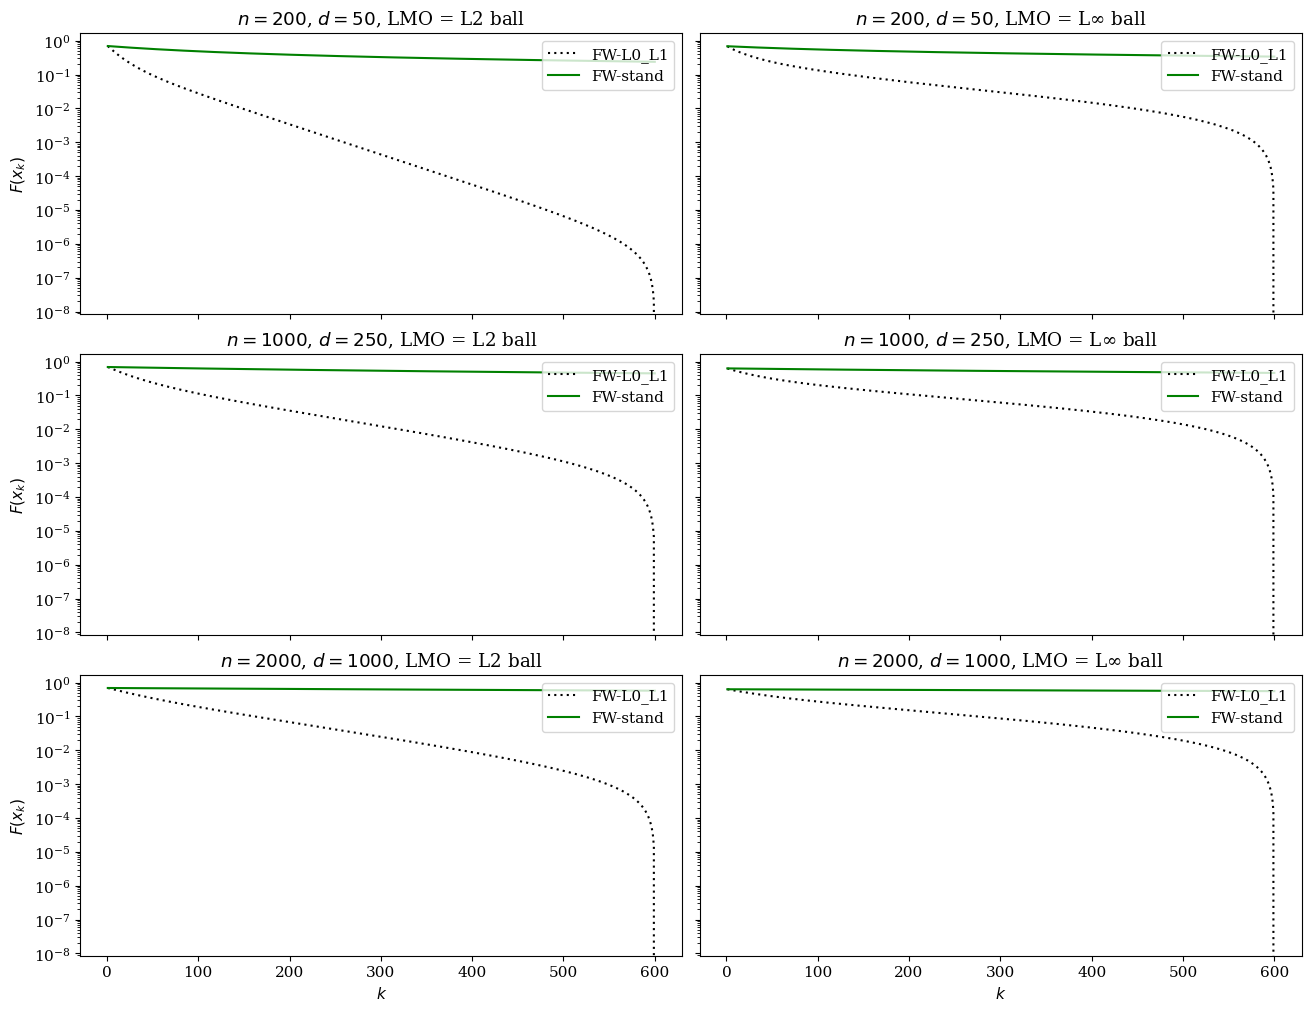

In [29]:
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

fig, axes = plt.subplots(3, 2, figsize=(13, 10), sharex=True, sharey=True, constrained_layout=True)

eps = 1e-14
max_iters = 600
verbskip = max_iters / 10
ls_ratio = 2.2

# parameters which ill be variated
ball_constrnt_radius = 250
n_samples, n_features = 1000, 25

# solution_spread_radius_btm = 0.95
# solution_spread_radius_up = 0.99


labels = [r"FW-L0_L1", r"FW-stand"]

configs = [
    (200, 50),
    (1000, 250),
    (2000, 1000),
]

lmo_names = ["L2 ball", "L∞ ball"]

for i, (n_samples, n_features) in enumerate(configs):
    np.random.seed(2025 + i)

    f, h, L, L0, L1, x0 = accbpg.L0L1_FW_log_reg(n_samples, n_features, ball_constrnt_radius)

    for j, (lmo, lmo_name) in enumerate(zip(
        [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)], lmo_names
    )):
        # Run FW-L0_L1
        _, F_l0l1, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio,
            epsilon=eps, linesearch=False, verbskip=verbskip
        )

        # Run FW-stand
        _, F_standard, _, _ = accbpg.FW_alg_div_step(
            f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo,
            epsilon=eps, linesearch=False, verbskip=verbskip
        )

        ax = axes[i, j]
        accbpg.plot_comparisons(
            ax,
            [F_l0l1, F_standard],
            labels,
            x_vals=[], plotdiff=True, yscale="log",
            xlabel=r"$k$" if i == 2 else "",
            ylabel=r"$F(x_k)$" if j == 0 else "",
            legendloc="upper right"
        )

        # Set informative title
        ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, LMO = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()


## Лог функция, адаптивные параметры. Эксперимент на датасете a9a Platt (1998)

Checking path: d:\projects\accbpg_and_fw\L0_L1_smoothness\datasets\a9a

FW L0,L1 smooth algorithm
     k      F(x)         L        log step count       time
     0    1.440e+00    1.289e+02        1         0.5
   150    5.263e-01    8.145e-02      151         3.0
   300    5.263e-01    4.492e-01      301         5.5
   450    5.263e-01    3.716e-01      451         8.0

FW adaptive algorithm
     k      F(x)         Lk       time
     0   1.440e+00   1.634e+04     0.0
   150   5.263e-01   9.976e-01     1.5
   300   5.263e-01   4.988e-01     3.1
   450   5.263e-01   4.988e-01     4.5
   600   5.263e-01   4.988e-01     6.0

FW L0,L1 smooth algorithm
     k      F(x)         L        log step count       time
     0    1.440e+00    1.289e+02        1         0.0
   150    5.266e-01    7.487e-01      151         2.5
   300    5.264e-01    5.984e-01      301         5.0
   450    5.263e-01    4.986e-01      451         7.5
   600    5.263e-01    8.698e-01      601        10.0
   750    5.

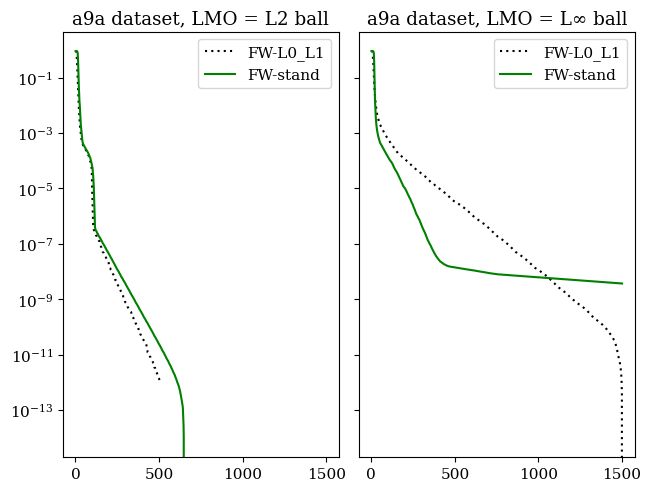

In [32]:
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True)

eps = 1e-14
radius = 250
max_iters = 1500
verbskip = max_iters / 10
ls_ratio = 2.0
gamma = 2.0
labels = [r"FW-L0_L1", r"FW-stand"]

base_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))  # from ipynb to parameters_free_fw/
path = os.path.join(base_path, "L0_L1_smoothness", "datasets", "a9a")
print(f"Checking path: {path}")

f, h, L, L0, L1, x0 = accbpg.L0L1_FW_log_reg_a9a(radius, path)

for i, (lmo, lmo_name) in enumerate(zip(
    [accbpg.lmo_l2_ball(radius), accbpg.lmo_linf_ball(radius)], ["L2 ball", "L∞ ball"]
)):
    # Run FW-L0_L1
    _, F_l0l1, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
        f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    # Run FW-stand
    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=gamma, lmo=lmo,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1, F_standard],
        labels,
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$" if i == 2 else "",
        ylabel=r"$F(x_k)$" if j == 0 else "",
        legendloc="upper right"
    )

    # Set informative title
    ax.set_title(f"a9a dataset, LMO = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()


## Выводы

1)  FW-L0_L1 четко быстрее при фиксированных реальных параметрах $L0, L1, L$ на любом множестве. 
2) Адаптивный FW-L0_L1 опережает только на l2 шаре и только на радиусах допустимого множества начиная примерно со 100 по евклидовой норме, остальные параметры на сходимость не влияют: удаленность начальной точки от решения, параметры самой целевой функции

Важные примечания:
- Сначала $L_2$ сильно осциллировл, затем я убрал регуляризацию и FW-L0_L1 нормализовался
- Почти всегда и везде выполнялся логарифмический шаг, т.е. всегда выполнялось условие $L_1 \| d_k \| \geq \text{ln}2$. ОДнако были экспреименты, где выполнялся и второй вид шага, но там на сходимость это шибко не влияло (в этих экспериментах этого нет)
- Пчму-то если матрица $A$ умножать на скаляр, то FW-L0_L1 начинает работать очень плохо
- Я пробовал адаптивность расчитывать по гессиану: $\| \nabla^2 f(x)\| \leq L_0 + L_1 \| \nabla f(x)\|$, но расчеты шли намного-намного дольше + сходимость почему-то сильно ухудшились. Однако, такое условие не подойдет так же и по идейным соображениям, т.к. нам нужно соответствие по 2-м точкам, а именно наш алгоритм работает на двух точках $x_{k+1}, x_k$, тут же мы ориентируемся только на одну. Т.е. так делать не надо.
